In [10]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc

from dnt import load_spots_data
from dnt import palettes, set_plot_style

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output")

set_plot_style()
spot_dfs, metadatas, stems = load_spots_data(spots_directory)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 14it [00:13,  1.06it/s]


In [4]:
pal = cc.glasbey

In [17]:
i = 1
spots_df = spot_dfs[i]
stem = stems[i]

viewer = napari.Viewer(ndisplay=3)

X = spots_df[["frame", "display_x", "display_y", "display_z"]].values
X[:, 1] = X[:, 1]*3
X[:, 1:] = X[:, 1:]*2
color = [pal[int(tid) % 100] for tid in spots_df["track_id"]]
size = spots_df["radius"] * 5

from napari.utils.theme import get_theme, register_theme
custom_theme = get_theme("dark")
custom_theme.canvas = "#D3BDB1"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")
viewer.theme = "glasbey"

points = viewer.add_points(
    X, face_color=color, size=size, name=f"spots_{i}", border_width=1.0, border_width_is_relative=False,
    antialiasing=1.0, border_color="#000000",
)

viewer.camera.angles = (0, 180, 90)
viewer.camera.zoom = 0.60

glasbey_save_path = save_path / "glasbey" / stem
glasbey_save_path.mkdir(parents=True, exist_ok=True)

In [18]:
for frame in tqdm(spots_df["frame"].unique()):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(glasbey_save_path / f"{frame:04d}.tif", canvas_only=True, scale=1, flash=False)

100%|██████████| 248/248 [00:13<00:00, 18.26it/s]


In [5]:
i = 1
spots_df = spots_dfs[i]
stem = stems[i]

viewer = napari.Viewer(ndisplay=3)

spots_df = spots_df[spots_df["display_z"] < spots_df["display_z"].mean()]
X = spots_df[["frame", "x", "y", "z"]].values

X[:, 1] = X[:, 1]*3
X[:, 1:] = X[:, 1:]*2
color = [pal[int(tid) % 100] for tid in spots_df["track_id"]]
size = spots_df["radius"] * 5

from napari.utils.theme import get_theme, register_theme
custom_theme = get_theme("dark")
custom_theme.canvas = "#ffffff"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")
viewer.theme = "glasbey"

points = viewer.add_points(
    X, face_color=color, size=size, name=f"spots_{i}", border_width=1.5, border_width_is_relative=False,
    antialiasing=0.0, border_color="#000000",
)

viewer.camera.angles = (0, 180, 90)
viewer.camera.zoom = 0.60

glasbey_save_path = save_path / "glasbey" / stem
glasbey_save_path.mkdir(parents=True, exist_ok=True)

In [6]:
for frame in tqdm(spots_df["frame"].unique()):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(glasbey_save_path / f"{frame:04d}.tif", canvas_only=True,flash=False)

100%|██████████| 246/246 [00:06<00:00, 38.82it/s]


In [6]:
i = 1
spots_df = spots_dfs[i]
stem = stems[i]

viewer = napari.Viewer(ndisplay=3)

# spots_df = spots_df[spots_df["display_z"] < spots_df["display_z"].mean()]
X = spots_df[["frame", "x", "y", "z"]].values

color = [pal[int(tid) % 100] for tid in spots_df["track_id"]]
size = spots_df["radius"] * 2

from napari.utils.theme import get_theme, register_theme
custom_theme = get_theme("dark")
custom_theme.canvas = "#ffffff"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")
viewer.theme = "glasbey"

points = viewer.add_points(
    X, face_color=color, size=size, name=f"spots_{i}", border_width=1.0, border_width_is_relative=False,border_color="#000000",
)

viewer.camera.angles = (0, 180, 90)
viewer.camera.zoom = 0.60

glasbey_save_path = save_path / "glasbey" / stem
glasbey_save_path.mkdir(parents=True, exist_ok=True)

In [14]:
i = 1
spots_df = spots_dfs[i]
stem = stems[i]

viewer = napari.Viewer(ndisplay=3)

X = spots_df[["frame", "x", "y", "z"]].values

# determine migration distance
spots_df["AP_from_start"] = spots_df["AP"] - spots_df["track_id"].map(spots_df.groupby("track_id")["AP"].first())
spots_df["tid_AP_from_start"] = 0.0
for frame, group in spots_df.groupby("frame"):
    spots_df.loc[group.index, "tid_AP_from_start"] = group["track_id"].map(group.groupby("track_id")["AP_from_start"].mean())

final_frame = spots_df["frame"].max()
frame_df = spots_df[spots_df["frame"] == final_frame]
full_lineages = frame_df.groupby("track_id")["frame"].count() > 13
lineages = frame_df["track_id"].unique()[full_lineages]

best_final_df = frame_df[frame_df["track_id"].isin(lineages)]
lineages = best_final_df.groupby("track_id").index
best_posterior = lineages[best_final_df.groupby("track_id")["tid_AP_from_start"].mean().argmax()]
best_anterior = lineages[best_final_df.groupby("track_id")["tid_AP_from_start"].mean().argmin()]
least_move = lineages[best_final_df.groupby("track_id")["tid_AP_from_start"].mean().abs().argmin()]
print(best_posterior, best_anterior, least_move)

color_map = {
    best_posterior: "red",
    best_anterior: "blue",
    least_move: "yellow"
}

color = [color_map.get(tid, "gray") for tid in spots_df["track_id"]]

# mm, mx = -0.075, 0.075
#
# color = sns.color_palette("vlag", as_cmap=True)((spots_df["tid_AP_from_start"] - mm) / (mx - mm))
#
size = spots_df["radius"] * 2
#
from napari.utils.theme import get_theme, register_theme
custom_theme = get_theme("dark")
custom_theme.canvas = "#EBDDC3"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")
viewer.theme = "glasbey"
#
points = viewer.add_points(
    X, face_color=color, size=size, name=f"spots_{i}", border_width=1.0, border_width_is_relative=False,
    antialiasing=1.0, border_color="#000000",
)
#
# viewer.camera.angles = (0, 180, 90)
# viewer.camera.zoom = 0.60
#
# migrator_save_path = save_path / "migration" / stem
# migrator_save_path.mkdir(parents=True, exist_ok=True)

AttributeError: 'DataFrameGroupBy' object has no attribute 'index'

In [11]:
i = 1
spots_df = spots_dfs[i]
stem = stems[i]

viewer = napari.Viewer(ndisplay=3)

X = spots_df[["frame", "x", "y", "z"]].values

# determine migration distance
spots_df["AP_from_start"] = spots_df["AP"] - spots_df["track_id"].map(spots_df.groupby("track_id")["AP"].first())
spots_df["tid_AP_from_start"] = 0.0
for frame, group in spots_df.groupby("frame"):
    spots_df.loc[group.index, "tid_AP_from_start"] = group["track_id"].map(group.groupby("track_id")["AP_from_start"].mean())

mm, mx = -0.075, 0.075

color = sns.color_palette("vlag", as_cmap=True)((spots_df["tid_AP_from_start"] - mm) / (mx - mm))

size = spots_df["radius"] * 2

from napari.utils.theme import get_theme, register_theme
custom_theme = get_theme("dark")
custom_theme.canvas = "#EBDDC3"
custom_theme.id = "glasbey"
register_theme("glasbey", custom_theme, "custom")
viewer.theme = "glasbey"

points = viewer.add_points(
    X, face_color=color, size=size, name=f"spots_{i}", border_width=1.0, border_width_is_relative=False,
    antialiasing=1.0, border_color="#000000",
)

viewer.camera.angles = (0, 180, 90)
viewer.camera.zoom = 0.60

migrator_save_path = save_path / "migration" / stem
migrator_save_path.mkdir(parents=True, exist_ok=True)

In [36]:
for frame in tqdm(spots_df["frame"].unique()):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(migrator_save_path / f"{frame:04d}.tif", canvas_only=True, scale=1, flash=False)

100%|██████████| 248/248 [00:12<00:00, 19.70it/s]


In [18]:
# import random
#
# i = 1
# spots_df = spots_dfs[i]
# stem = stems[i]
#
# viewer = napari.Viewer(ndisplay=3)
#
# X = spots_df[["frame", "display_x", "display_y", "display_z"]].values
#
# spots_df["pseudotime_nona"] = spots_df["pseudotime"].fillna(0)
#
# mm, mx = 0, 1
#
# color = sns.color_palette("hsv", as_cmap=True)((spots_df["pseudotime_nona"] - mm) / (mx - mm))
# color[spots_df["pseudotime"].isna()] = [0.33, 0.33, 0.33, 1.0]  # gray for missing values
#
# size = spots_df["radius"] * 2.5
#
# from napari.utils.theme import get_theme, register_theme
# custom_theme = get_theme("dark")
# custom_theme.canvas = "#D3BDB1"
# custom_theme.id = "glasbey"
# register_theme("glasbey", custom_theme, "custom")
# viewer.theme = "glasbey"
#
# points = viewer.add_points(
#     X, face_color=color, size=size, name=f"spots_{i}", border_width=1.0, border_width_is_relative=False,
#     antialiasing=1.0, border_color="#000000",
# )
#
# viewer.camera.angles = (0, 180, 90)
# viewer.camera.zoom = 0.60
#
# # migrator_save_path = save_path / "migration" / stem
# # migrator_save_path.mkdir(parents=True, exist_ok=True)

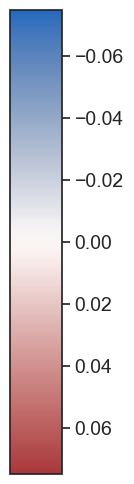

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap_name = "vlag"


fig, ax = plt.subplots(figsize=(1.5, 5))

cmap = sns.color_palette("vlag", as_cmap=True) # Choose a colormap, e.g., 'viridis', 'plasma', 'coolwarm'
norm = mpl.colors.Normalize(vmin=-0.075, vmax=0.075) # Define the data range for the colorbar

# make figure transparent
fig.patch.set_alpha(0.0)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, cax=ax, orientation='vertical', label='Units of Measurement')

cbar.ax.tick_params(labelsize=14)
cbar.set_label('', fontsize=16, loc="center")

# Adjust layout to prevent labels from overlapping
plt.tight_layout()
ax.invert_yaxis()  # Invert the y-axis to match the direction of the colormap

# Save the figure with a high resolution for presentation quality
plt.savefig(save_path / 'migration.png', dpi=300)